In [1]:
%matplotlib inline
import numpy as np

from scipy.stats import linregress
from scipy.stats import gmean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

4.528440318129362


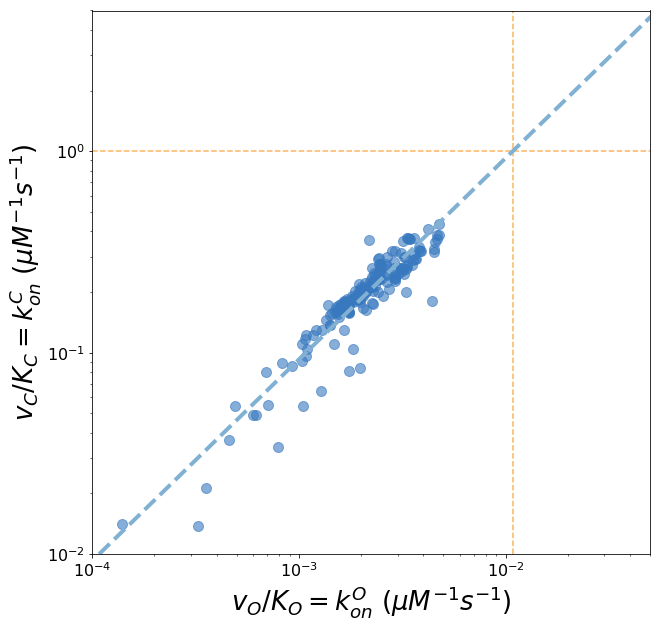

In [3]:
konC = np.logspace(-2, 1)  # /s
ln_konC = np.log(konC)
C = np.log(92.614)
print(C)
ln_konO = ln_konC - C
konO = np.exp(ln_konO)

figure = plt.figure(figsize=(10, 10))
colors = seaborn.color_palette("Set3", 8)

plt.loglog(konO, konC, ls='--', color=colors[4], lw=4, zorder=10)
plt.axhline(1e0, color=colors[5], ls='--')
plt.axvline(np.exp(-C), color=colors[5], ls='--')

fI_data = raw_kin_df[raw_kin_df.isoform == '1']
c = matplotlib.colors.rgb2hex(named_colors[0])

plt.scatter(fI_data.kon_O, fI_data.kon_C, c=c, s=100, alpha=0.6)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 0.05)
plt.ylim(1e-2, 5)

plt.xlabel('$v_O / K_O = k_{on}^O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$v_C / K_C = k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)

plt.savefig('fig6/fig6_konC_konO.png', dpi=600)
plt.savefig('fig6/fig6_konC_konO.svg')
plt.show()

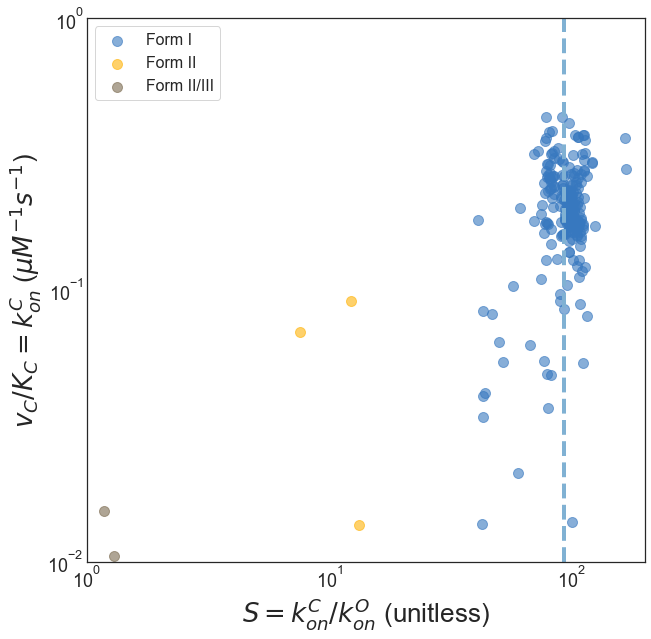

In [4]:
C = 92.614
Cmin, Cmax = 88.22922197, 95.57987783

# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
seaborn.set_style('white')

plt.xscale('log')
plt.yscale('log')

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group == '3':
        continue
    label = 'Form %s' % groups[group]
    c = matplotlib.colors.rgb2hex(named_colors[i])
    plt.scatter(gdf.S, gdf.vC/gdf.KC,  c=c, s=100, label=label, alpha=0.6)
    
# Range on C
plt.axvline(C, color=colors[4], ls='--', lw=4)
#plt.axvspan(Cmin, Cmax, color=colors[4], alpha=0.4, zorder=-1)

    
plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$S = k_{on}^C / k_{on}^O$ (unitless)', fontsize=26)
plt.ylabel('$v_C / K_C = k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(1e0, 2e2)
plt.ylim(1e-2, 1e0)

plt.savefig('fig6/fig6_konC_S.png', dpi=600)
plt.savefig('fig6/fig6_konC_S.svg')

plt.show()

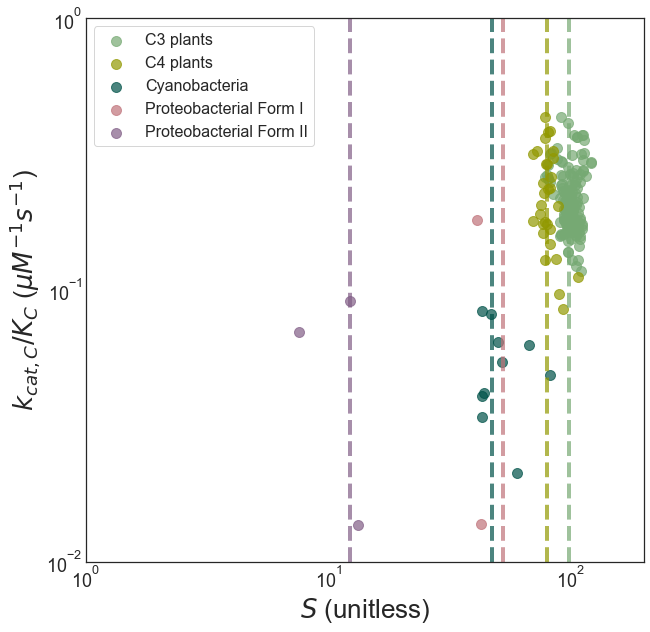

In [5]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
seaborn.set_style('white')

plt.xscale('log')
plt.yscale('log')

F1_data = raw_kin_df[raw_kin_df.isoform == '1']
F2_data = raw_kin_df[raw_kin_df.isoform == '2']

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'C3-C4 plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Green algae': 'Green algae',
                 'Non-green algae': 'Non-green algae',
                 'Alphaproteobacteria': 'Proteobacterial Form I',
                 'Betaproteobacteria': 'Proteobacterial Form I',
                 'Gammaproteobacteria': 'Proteobacterial Form I',
                }
color_mapping = {
    'C3 plants': 'dusty green',
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Non-green algae': 'dusty red',
    'Proteobacterial Form I': 'dusty rose',
}
grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)
taxa_to_plot = set(['C3 plants', 'C4 plants', 'Cyanobacteria', 'Proteobacterial Form I'])

for i, (group, gdf) in enumerate(grouped_taxa):
    if group not in taxa_to_plot:
        continue
        
    cname = color_mapping[group]
    c = seaborn.xkcd_rgb[cname]
    
    plt.scatter(gdf.S, gdf.vC/gdf.KC,  c=c, s=100, label=group, alpha=0.7)
    
    median_s = np.nanmedian(gdf.S)
    plt.axvline(median_s, color=c, ls='--', alpha=0.7, lw=4)


cname = 'dusty purple'
c = seaborn.xkcd_rgb[cname]
plt.scatter(F2_data.S, F2_data.vC/F2_data.KC,  c=c, s=100, label='Proteobacterial Form II', alpha=0.7)

median_s = np.nanmedian(F2_data.S)
plt.axvline(median_s, color=c, ls='--', alpha=0.7, lw=4)

    
plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$S$ (unitless)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(1e0, 2e2)
plt.ylim(1e-2, 1e0)

plt.savefig('fig6/fig6_konC_S_by_group.png', dpi=600)
plt.savefig('fig6/fig6_konC_S_by_group.svg')

plt.show()